# RUN THESE CELLS, BUT DO NOT CHANGE THEM

In [20]:
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import HeteroConv
from torch_geometric.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

import warnings
warnings.filterwarnings(action='once')

In [21]:
class MusicDataset():
    def __init__(self):
        composers = ['Bach', 'Ravel', 'Chopin', 'Haydn']
        self.composer_to_i = {composer: i for i, composer in enumerate(composers)}
        self.i_to_composer = {i: composer for composer, i in self.composer_to_i.items()}
        self.num_classes = len(composers)

        dataset_path = "asap-dataset-master\\asap-dataset-master"
        self.paths = [str(path) for path in Path(dataset_path).rglob('*.musicxml')]
        self.composers = [piece for path in self.paths for piece in path.split("\\") if piece in composers]
        self.graph_data_list = []
        self.composer_counter = Counter()
        for i, (path, composer) in enumerate(zip(self.paths, self.composers)):
            if composer not in self.composer_to_i.keys():
                continue
            try:
                y = self.composer_to_i[composer]
                self.graph_data_list = process_file(path, y, self.graph_data_list)
            except KeyError as e:
                print(e)
        for data in self.graph_data_list:
            self.composer_counter[self.i_to_composer[data[2]]] += 1
        print(self.composer_counter)

    def __len__(self):
        return len(self.graph_data_list)

    def __getitem__(self, idx):
        return self.graph_data_list[idx]

    def visualize(self, idx):
        pass

In [22]:
def broadcast(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out = None,
                dim_size = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)

## GNN Stack Module

Below is the implementation for a general GNN Module that is provided for you. Your **GAT** layers will function as components in the GNNStack Module.

In [23]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, heads, dropout, emb=False):
        super(GNNStack, self).__init__()
        conv_model = GAT

        assert (num_layers >= 1), 'Number of layers is not >=1'

        edge_types = [
            ('note', edge_type, 'note')
            for edge_type in [
                'forward', 'voice', 'onset',
                'rest', 'slur', 'sustain'
            ]
        ]

        self.convs = nn.ModuleList()
        self.convs.append(
            HeteroConv({
                edge_type: conv_model(input_dim, hidden_dim)
                for edge_type in edge_types
            })
        )
        for l in range(num_layers - 1):
            self.convs.append(
                HeteroConv({
                    edge_type: conv_model(heads * hidden_dim, hidden_dim)
                    for edge_type in edge_types
                })
            )

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(heads * hidden_dim, hidden_dim), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim))

        self.predict = nn.Linear(hidden_dim, output_dim)

        self.dropout = dropout
        self.num_layers = num_layers

        self.emb = emb

        self.loss_class = nn.CrossEntropyLoss()

    def forward(self, data):
        # x, edge_index, batch = data.x, data.edge_index, data.batch
        names, hetero_data_batch, y = data
        x = hetero_data_batch['note']['x']
        x = {'note': x}
        for i in range(self.num_layers):
            x = self.convs[i](x, hetero_data_batch.edge_index_dict)
            x['note'] = F.relu(x['note'])
            x['note'] = F.dropout(x['note'], p=self.dropout)

        x['note'] = self.post_mp(x['note'])
        x['note'] = x['note'].view(-1, 50, x['note'].size(1))

        x['note'] = x['note'].mean(dim=1)
        x['note'] = self.predict(x['note'])

        if self.emb == True:
            return x

        # return torch.argmax(F.softmax(x['note'], dim=1), dim=1)
        return x['note']

    def loss(self, pred, label):
        return self.loss_class(pred, label)

# ------------------------------------------------------------------------------------

# The Problem Proper Starts Here!

## Creating Our Own Message Passing Layer

We are going to implement our own message passing layer! Working through this part will help us become acutely familiar with the behind the scenes work of implementing Pytorch Message Passing Layers, allowing us to build our own GNN models. We will implement 2 critical functions needed to define a PyG Message Passing Layer: `forward` and `message`.

First let's review the message passing process. We focus on a single round of message passing with respect to a single central node $x$, which is associated with a feature vector $x^l$ after a particular message passing layer $l$. The goal of message passing is to update this feature vector from $x^l$ to $x^{l+1}$. We accomplish this through the following steps:

1. Each neighboring node $v$ passes its current message $v^{l}$ across the edge $(x, v)$.

2. For the node $x$, we aggregate all of the messages of the neighboring nodes through a permutation-invariant function such as the sum or mean.

3. We transform the aggregated information using learned weights to produce $x^{l+1}$.

Altogether, the message passing process is applied such that every node in our graph updates its embedding by acting as the central node $x$ in steps 1-3 described above.

Now, we extend this process to that of a single message passing layer. A message passing layer updates the current feature representation or embedding of each node in a graph by propagating and transforming information within the graph. Overall, the general paradigm of a message passing layers is:
1. pre-processing
2. **message passing** / propagation
3. post-processing.

The `forward` function that we will implement for our message passing layer captures this execution logic. Namely, the `forward` function handles the pre and post-processing of node features / embeddings, as well as initiates message passing by calling the `propagate` function.

The `propagate` function encapsulates the message passing process. It does so by calling three important functions: 1) `message`, 2) `aggregate`, and 3) `update`. Our implementation will vary slightly from this, as we will not explicitly implement `update`, but instead place the logic for updating node embeddings after message passing and within the `forward` function. To be more specific, after information is propagated (message passing), we can further transform the node embeddings output by `propagate`. Therefore, the output of `forward` is exactly the node embeddings after one GNN layer.

Before starting to implement our own layer, let's dig a bit deeper into the functions described above:

```
def propagate(edge_index, x=(x_i, x_j), extra=(extra_i, extra_j), size=size):
```
Calling `propagate` initiates the message passing process. Let's look at a few key parameters.

  - `edge_index` is passed to the forward function and captures the edge structure of the graph. It is a $2 \times \text{len}(E)$ tensor where $E$ is the set of all edges in the graph. Every column describes the source and target node associated with an edge.
  - `x=(x_i, x_j)` represents the node features that will be used in message passing. In order to explain why we pass the tuple `(x_i, x_j)`, we first look at how our edges are represented. For every edge $(i, j) \in {E}$, we can differentiate $i$ as the source or central node ($x_{central}$) and j as the target or neighboring node ($x_{neighbor}$).
  - `extra=(extra_i, extra_j)` represents additional information that we can associate with each node beyond its current feature embedding. In fact, we can include as many additional parameters of the form `param=(param_i, param_j)` as we would like. Again, we highlight that indexing with `_i` and `_j` allows us to differentiate central and neighboring nodes.

The output of the `propagate` function is a matrix of node embeddings after the message passing process and has shape $N \times d$, where $N$ is the number of nodes and $d$ (a hyperparameter) is the dimension of a node feature vector.

```
def message(x_j, ...):
```
The `message` function is called by propagate and constructs the messages from
neighboring nodes $j$ to central nodes $i$ for each edge $(i, j)$ in *edge_index*. This function can take any argument that was initially passed to `propagate`. Furthermore, we can again differentiate central nodes and neighboring nodes by appending `_i` or `_j` to the variable name, .e.g. `x_i` and `x_j`. Looking more specifically at the variables, we have:

  - `x_j` represents a matrix of feature embeddings for all neighboring nodes passing their messages along their respective edge (i.e. all nodes $j$ for edges $(i, j) \in {E}$). Thus, its shape is $|{E}| \times d$.
  - In implementing GAT we will see how to access additional variables passed to propagate

Critically, we see that the output of the `message` function is a matrix of neighboring node embeddings ready to be aggregated, having shape $|{E}| \times d$.


```
def aggregate(self, inputs, index, dim_size = None):
```
Lastly, the `aggregate` function, which we have implemented for you, is used to aggregate the messages from neighboring nodes. Looking at the parameters:

  - `inputs` represents a matrix of the messages passed from neighboring nodes (i.e. the output of the `message` function).
  - `index` has the same shape as `inputs` and tells us the central node that corresponding to each of the rows / messages $j$ in the `inputs` matrix. Thus, `index` tells us which rows / messages to aggregate for each central node.

The output of `aggregate` is of shape $N \times d$.


For additional resources refer to the PyG documentation for implementing custom message passing layers: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

## GAT Implementation

As we discuss in question 3, attention mechanisms have become the state-of-the-art in many sequence-based tasks such as machine translation and learning sentence representations. One of the major benefits of attention-based mechanisms is their ability to focus on the most relevant parts of the input to make decisions. Here, we will see how attention mechanisms can be used in Graph Neural Networks by implementing a Graph Attention Network (GAT).

We focus on the graph attention layer, which is a variant of the aggregation function. Let $n$ be the number of nodes and $d$ be the dimension of the feature vector for each node. The input to each graph attentional layer is a set of node features: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_n}$\}, such that $\overrightarrow{h_i} \in \mathbb{R}^d$. The output of each graph attentional layer is a new set of node features, which may have a new dimension $d'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_n'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{d'}$.

We will now describe this transformation of the input features into higher-level features performed by each graph attention layer. First, a shared linear transformation parametrized by the weight matrix $\mathbf{W} \in \mathbb{R}^{d' \times d}$ is applied to every node. Next, we perform self-attention on the nodes. We use a shared attentional mechanism:
\begin{equation}
a : \mathbb{R}^{d'} \times \mathbb{R}^{d'} \rightarrow \mathbb{R}.
\end{equation}

This mechanism computes the attention coefficients that capture the importance of node $j$'s features to node $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
The most general formulation of self-attention allows every node to attend to all other nodes which drops all structural information. To utilize graph structure in the attention mechanisms, we can use masked attention. In masked attention, we only compute $e_{ij}$ for nodes $j \in \mathcal{c}_i$ where $\mathcal{c}_i$ is some neighborhood of node $i$ in the graph.

To easily compare coefficients across different nodes, we normalize the coefficients across $j$ using a softmax function:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{c}_i} \exp(e_{ik})}
\end{equation}

For this problem, our attention mechanism $a$ will be a single-layer feedforward neural network parametrized by a weight vector $\overrightarrow{a} \in \mathbb{R}^{d'}$, followed by a LeakyReLU nonlinearity (with negative input slope 0.2). Let $\cdot^T$ represent transposition and $||$ represent concatenation. The coefficients computed by our attention mechanism may be expressed as:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{c}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

We denote `alpha_l` = $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...] \in R^n$ and `alpha_r` = $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...] \in R^n$.


At every layer of GAT, after the attention coefficients are computed for that layer, the aggregation function can be computed by a weighted sum of neighborhood messages, where weights are specified by $\alpha_{ij}$.

Now, we use the normalized attention coefficients to compute a linear combination of the features corresponding to them. These aggregated features will serve as the final output features for every node.

\begin{equation}
h_i' = \sum_{j \in \mathcal{c}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

To stabilize the learning process of self-attention, we use multi-head attention. To do this we use $K$ independent attention mechanisms, or "heads" compute output features as in the above equations. Then, we concatenate these output feature representations:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{c}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

where $||$ is concentation, $\alpha_{ij}^{(k)}$ are the normalized attention coefficients computed by the $k$-th attention mechanism $(a^k)$, and $\mathbf{W}^{(k)}$ is the corresponding input linear transformation's weight matrix. Note that for this setting, $\mathbf{h'} \in \mathbb{R}^{K\cdot \,d'}$.

In [24]:
class GAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=2,
                 negative_slope=0.2, dropout=0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
        self.lin_r = self.lin_l

        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size=None):
        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # Our implementation is ~6 lines, but don't worry if you deviate from this.
        ############################################################################

        # Pass embeddings through the provided linear layers and split the result into multiple heads
        x_l = self.lin_l(x).view(-1, H, C)
        x_r = self.lin_r(x).view(-1, H, C)

        # Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r)
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = (x_r * self.att_r).sum(dim=-1)

        # Call the propogate method to begin message passing. Remember to pass alpha=(alpha_l, alpha_r) as a parameter
        # For more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        out = self.propagate(edge_index, x=(x_l, x_r), 
                             alpha=(alpha_l, alpha_r), size=size)

        # Combine heads to return to the original shape of N * d
        #out = ...
        out = out.view(-1, self.heads * self.out_channels)
        ############################################################################

        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function.
        # Our implementation is ~4 lines, but don't worry if you deviate from this.
        ############################################################################

        # Calculate the final attention weights using alpha_i and alpha_j and apply leaky Relu.
        att_weight = F.leaky_relu(alpha_j + alpha_i, negative_slope=self.negative_slope)

        # Calculate over the neighbor nodes for all the nodes. Use torch_geometric.utils.softmax instead of the one in Pytorch
        att_weight = torch_geometric.utils.softmax(att_weight, index, ptr, size_i)
        # Apply dropout to attention weights (alpha)
        att_weight = F.dropout(att_weight, p=self.dropout, training=self.training)

        # Multiply embeddings and attention weights. As a sanity check, the output should be of shape E * H * d
        out = x_j * att_weight.unsqueeze(-1)
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size=None):
        out = scatter_sum(inputs, index, self.node_dim, dim_size=dim_size)
        return out

## Training and Testing

Here we provide you with the functions to train and test. **Please do not modify this part for grading purposes.**

In [25]:
def train(dataset, args):
    # print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(50, args.hidden_dim, dataset.num_classes,
                     args.num_layers, args.heads, args.dropout)

    filter_fn = filter(lambda p: p.requires_grad, model.parameters())
    opt = optim.Adam(filter_fn, lr=args.lr, weight_decay=args.weight_decay)

    test_acc, preds, labels = validate(test_loader, model)
    print("Before training test Acc.: ", test_acc)

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch[2]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 1 == 0:
            test_acc, preds, labels = validate(test_loader, model)
            test_accs.append(test_acc)
            print("Epoch ", epoch, "Loss: ", total_loss, "Test Acc.: ", test_acc)
        else:
            test_accs.append(test_accs[-1])

        if epoch % 10 == 0 or (test_acc > max(test_accs[:-1]) and epoch > 30):
          torch.save(model.state_dict(), f'model_{epoch}.pth')
    return test_accs, losses


def validate(loader, model, is_validation=True):
    model.eval()

    correct = 0
    total = 0
    preds = []
    labels = []
    for batch in loader:
        with torch.no_grad():
            pred = model(batch)
            pred = torch.argmax(pred, dim=1)
            label = batch[2]

        correct += pred.eq(label).sum().item()
        total += len(batch[0])
        preds += pred.flatten().tolist()
        labels += label.flatten().tolist()


    return correct / total, preds, labels

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

The following code will train the model, printing the loss and accuracy at each epoch. It should run pretty quickly, particularly with larger batch sizes and fewer layers and hidden dimensions. Play around with these parameters and see if you can get accuracy above 83% within 50 epochs. **You must at least reach an accuracy of 80% for full points.**

Every 10th model will be saved as well as any model that receives the highest accuracy after 30 epochs.

**TODO: Briefly justify your parameter choices, particularly your choice for num_layers.**

I choose a small number of layers as we wanted it to learn fast. Batch size of 32 to hopefully get scraps of each artist into most batchs (also to stabilize the training a bit). Hidden_dim of 32 as there is a decent amount of infomation to learn from the music. LR of 0.0035, again we wanted to learn fast and be able to get away from local minim quickly so a largish LR was chosen.

Before training test Acc.:  0.23497386759581881
Epoch  0 Loss:  0.024152844761358736 Test Acc.:  0.7628484320557491
Epoch  1 Loss:  0.020529896585523875 Test Acc.:  0.7674216027874564
Epoch  2 Loss:  0.01982343538245673 Test Acc.:  0.7674216027874564
Epoch  3 Loss:  0.019695175480655677 Test Acc.:  0.7722125435540069
Epoch  4 Loss:  0.019160229829545634 Test Acc.:  0.7783101045296167
Epoch  5 Loss:  0.01844734922440833 Test Acc.:  0.7820121951219512
Epoch  6 Loss:  0.018459706894975506 Test Acc.:  0.7770034843205574
Epoch  7 Loss:  0.01817152048834317 Test Acc.:  0.7848432055749129
Epoch  8 Loss:  0.018056958342678456 Test Acc.:  0.7815766550522648
Epoch  9 Loss:  0.017405484436332972 Test Acc.:  0.7793989547038328
Epoch  10 Loss:  0.017251240310197508 Test Acc.:  0.7878919860627178
Epoch  11 Loss:  0.017062545916266766 Test Acc.:  0.7972560975609756
Epoch  12 Loss:  0.017138530782550468 Test Acc.:  0.8027003484320557
Epoch  13 Loss:  0.016548360256601502 Test Acc.:  0.802918118466899


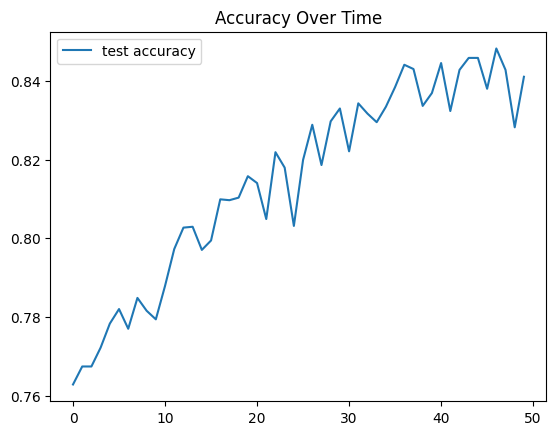

In [36]:
args = {
  'model_type': 'GAT',
  'heads': 2,
##########################################
# TODO: You should only experiment with these parameters
  'num_layers': 2,
  'batch_size': 32,
  'hidden_dim': 32,
  'epochs': 50,
  'lr': 0.0035,
##########################################
  'dropout': 0.5,
  'opt': 'adam',
  'opt_scheduler': 'none',
  'opt_restart': 0,
  'weight_decay': 0,
}
args = objectview(args)

with open("music_data.pkl", 'rb') as f:
    dataset = pickle.load(f)
test_accs, losses = train(dataset, args)

print("Maximum accuracy:", max(test_accs))
print("Minimum loss:", min(losses))

plt.title("Accuracy Over Time")
plt.plot(test_accs, label="test accuracy")
plt.legend()
plt.show()


The following block loads the saved models associated with certain epochs and plots the confusion matrix associated with its predictions. **Choose a few models to examine.**

/tmp/ipykernel_65247/3932488156.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{epoch}.pth'))


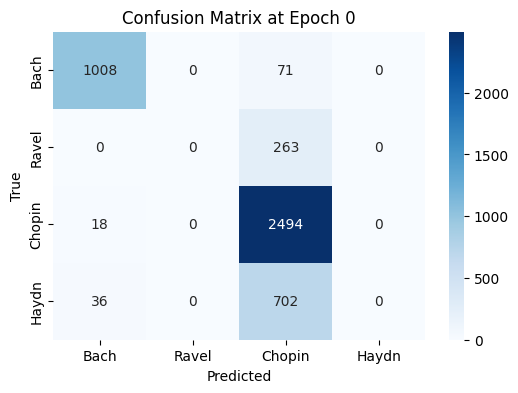

/tmp/ipykernel_65247/3932488156.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{epoch}.pth'))
/home/vscode/.local/lib/python3.

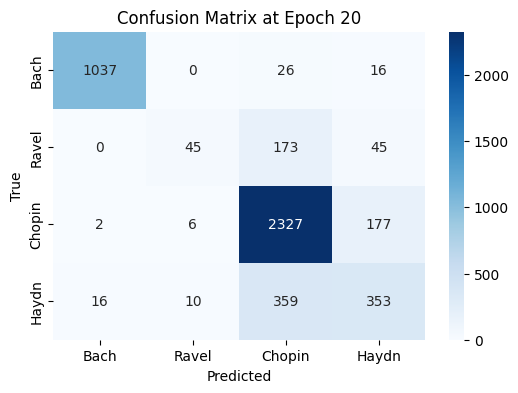

/tmp/ipykernel_65247/3932488156.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{epoch}.pth'))
/home/vscode/.local/lib/python3.

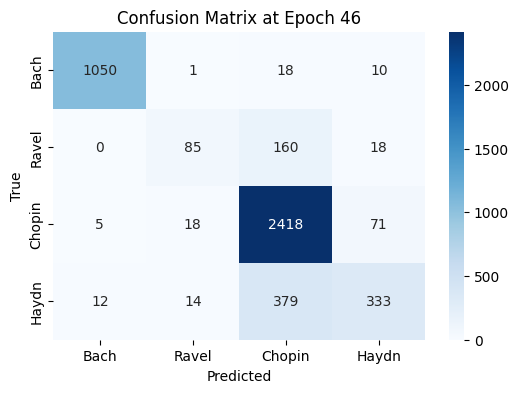

In [37]:
############################################
# TODO: Choose which saved models to load
epochs_to_load = [0, 20, 46]
############################################

model = GNNStack(50, args.hidden_dim, dataset.num_classes,
                     args.num_layers, args.heads, args.dropout)

for epoch in epochs_to_load:
  model.load_state_dict(torch.load(f'model_{epoch}.pth'))
  test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
  test_acc, preds, labels = validate(test_loader, model)

  # Generate the confusion matrix
  cm = confusion_matrix(labels, preds)

  # Visualize the confusion matrix
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.xticks(ticks=np.arange(0.5, 4, 1), labels=[composer for composer, i in dataset.composer_to_i.items()])
  plt.yticks(ticks=np.arange(0.5, 4, 1), labels=[composer for composer, i in dataset.composer_to_i.items()])
  plt.title(f'Confusion Matrix at Epoch {epoch}')
  plt.show()

# TODO: Analysis

What does the model struggle to learn? Describe at least two possible ways to overcome this issue.

The model struggles to learn/predict groups with a smaller group size. AKA. when the groups are heavily unbalanced it struggles to predict the smaller groups (especially when they are 'close' to a bigger group).

1. One way that might help this is to argument the data in the smaller groups. You could do this by coping the data (from a smaller group) and then adding some noise until the group sizes are similar sizes.
2. Another thing that might help is to weight smaller class more. AKA if one class has less data you can have the model give more weight to predicting that class to help force it to learn that class. 

(Optional) For an extra point, from a musical perspective, why might the results trend the way that they do?

From a musical perspective Ravel, Chopin and Haydn have somewhat more similar music compared to Bach. As such it makes sense that the model has more trouble distinguishing them and not as much trouble with Bach.